In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from ent_likelihood import Likelihood
from samples import Samples
import constants as c

from ent_data_simulation import params_injected

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from ent_data_simulation.pulsar_phase import get_psr_phase

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# load Enterprise pulsar data
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
toas = jnp.array(data_dict['toas'])
residuals = jnp.array(data_dict['residuals'])
Tspans = toas[:, -1] - toas[:, 0]
Tspan = jnp.mean(Tspans)
Tspan_yr = Tspan / c.year_sec
Np = toas.shape[0]
Ntoas = toas.shape[1]
psr_pos = jnp.array(data_dict['psr_pos'])
psr_dists = jnp.array(data_dict['psr_dists'])
psr_dists_inj = psr_dists[0]
psr_dists_stdev = psr_dists[1]
Fs = jnp.array(data_dict['Fs'])
Ms = jnp.array(data_dict['Ms'])
Rs = jnp.array([jnp.eye(Ntoas) - M @ jnp.linalg.inv(M.T @ M) @ M.T
                for M in Ms])
U_s = jnp.array([jnp.linalg.svd(M)[0]
                 for M in Ms])
Gs = jnp.array([U[:, 8:] for U in U_s])
Ns = jnp.array(data_dict['Ns'])
Ntinvs = jnp.array([G @ jnp.linalg.inv(G.T @ N @ G) @ G.T
                    for G, N in zip(Gs, Ns)])
psr_names = data_dict['psr_names']
x_inj_dict = data_dict['x_inj'].item()

Np = toas.shape[0]
Ntoas = toas.shape[1]
Nf = params_injected.num_modes
Na = 2 * Nf

In [13]:
pta_for_params = PTA(Np=Np,
                     Tspan_yr=15,
                     Nf=params_injected.num_modes,
                     model_wn=False,
                     model_rn=params_injected.rn_model,
                     model_gwb=params_injected.gwb_model,
                     model_cw=params_injected.cw_model,
                     Enterprise_bounds=True,
                     Nf_cw=15)

In [14]:
if Fs.shape == (Np, Ntoas, 0):
    freqs = jnp.arange(1, Nf + 1) / Tspan
    Fs = jnp.zeros((Np, Ntoas, Na))
    for i in range(Np):
        for j in range(Nf):
            Fs = Fs.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                            freqs[j] * toas[i]))
            Fs = Fs.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                                freqs[j] * toas[i]))

In [15]:
N_cw = 8
N_psr = 2 * Np
N_cw_psr = N_cw + N_psr
window_ext_yr = pta_for_params.window_ext_yr
Nf_cw = pta_for_params.Nf_cw
Na_cw = pta_for_params.Na_cw
from scipy.signal.windows import tukey


# window extension for CW FFT (avoids Gibbs phenomena)
window_ext_yr = window_ext_yr
window_ext = window_ext_yr * c.year_sec

# extended Tspan for CW FFT
Tspan_ext_yr = Tspan_yr + 2. * window_ext_yr
Tspan_ext = Tspan_ext_yr * c.year_sec

# sparse TOAs for CW FFT
sparse_toas_CW = jnp.array([jnp.linspace(toas[idx][0] - window_ext,
                                                toas[idx][-1] + window_ext,
                                                Na_cw + 2, endpoint=False)
                                    for idx in range(Np)])  # (Np, N_sparse)
Nsparse = sparse_toas_CW.shape[1]
freqs_forFFT = jnp.array([jnp.fft.fftfreq(Nsparse, Tspan_ext / Nsparse)
                                for _ in range(Np)])

# Fourier design matrix for CW
Fs_cw = jnp.zeros((Np, Ntoas, Na_cw))
for i in range(Np):
    for j in range(Nf_cw):
        Fs_cw = Fs_cw.at[i, :, 2 * j].set(jnp.sin(2. * jnp.pi * \
                                                    freqs_forFFT[i, j + 1] * toas[i]))
        Fs_cw = Fs_cw.at[i, :, 2 * j + 1].set(jnp.cos(2. * jnp.pi * \
                                                        freqs_forFFT[i, j + 1] * toas[i]))            

# Tukey window for FFT
Tukey_cw = tukey(Nsparse, alpha=window_ext_yr/Tspan_ext_yr)
Tukey_cw = jnp.array(Tukey_cw)

In [16]:
# antenna pattern for continuous waves
@jit
def create_gw_antenna_pattern(gwtheta, gwphi):
    '''
    Creates a continuous gravitational wave antenna pattern.

    param: gwtheta: theta coordinate for sky location of CW source
    param: gwphi: phi coordinate for sky location of CW source
    '''

    # use definition from Sesana et al 2010 and Ellis et al 2012
    sgwphi = jnp.sin(gwphi)
    cgwphi = jnp.cos(gwphi)
    sgwtheta = jnp.sin(gwtheta)
    cgwtheta = jnp.cos(gwtheta)

    mdotpos = sgwphi * psr_pos[:, 0] - cgwphi * psr_pos[:, 1]
    ndotpos = -cgwtheta * cgwphi * psr_pos[:, 0] - cgwtheta * sgwphi * psr_pos[:, 1] \
                + sgwtheta * psr_pos[:, 2]
    omhatdotpos = -sgwtheta * cgwphi * psr_pos[:, 0] - sgwtheta * sgwphi * psr_pos[:, 1] \
                    -cgwtheta * psr_pos[:, 2]

    fplus = 0.5 * (mdotpos ** 2 - ndotpos ** 2) / (1 + omhatdotpos)
    fcross = (mdotpos * ndotpos) / (1 + omhatdotpos)
    cosMu = -omhatdotpos

    return fplus, fcross, cosMu

In [17]:
# get signal due to continuous wave
@jit
def cw_delay(x_CW):
    '''
    Returns CW signal over sparse TOAs given CW parameters, pulsar parameters, and
    position of pulsar.
    
    params: x_CW: jax array of continuous wave parameters
    '''
    # unpack parameters
    log10_mc, log10_fgw, cos_inc, psi, log10_dist, cos_gwtheta, gwphi, phase0 = x_CW[:N_cw]
    p_phases = x_CW[N_cw : N_cw + Np]
    pdists = x_CW[N_cw + Np:]

    # convert units to time
    mc = 10 ** log10_mc * c.Tsun
    fgw = 10 ** log10_fgw
    gwtheta = jnp.arccos(cos_gwtheta)
    inc = jnp.arccos(cos_inc)
    p_dists = pdists * c.kpc / c.c
    dist = 10 ** log10_dist * c.Mpc / c.c

    # get antenna pattern funcs and cosMu
    # write function to get pos from theta,phi
    fplus, fcross, cosMu = create_gw_antenna_pattern(gwtheta, gwphi)

    # get pulsar time
    toas_copy = sparse_toas_CW - pta_for_params.tref
    tp = toas_copy - (p_dists*(1-cosMu))[:, None]

    # orbital frequency
    w0 = jnp.pi * fgw
    phase0 = phase0 / 2.0  # convert GW to orbital phase

    # calculate time dependent frequency at earth and pulsar
    mc53 = mc**(5./3.)
    w083 = w0**(8./3.)
    fac1 = 256./5. * mc53 * w083
    omega = w0 * (1. - fac1 * toas_copy)**(-3./8.)
    omega_p = w0 * (1. - fac1 * tp)**(-3./8.)
    omega_p0 = (w0 * (1. + fac1 * p_dists*(1-cosMu))**(-3./8.))[:, None]

    # calculate time dependent phase
    phase = phase0 + 1./32./mc53 * (w0**(-5./3.) - omega**(-5./3.))

    phase_p = (phase0 + p_phases[:, None]
                + 1./32./mc53 * (omega_p0**(-5./3.) - omega_p**(-5./3.)))

    # define time dependent coefficients
    inc_factor = -0.5 * (3. + jnp.cos(2. * inc))
    At = jnp.sin(2. * phase) * inc_factor
    Bt = 2. * jnp.cos(2. * phase) * cos_inc
    At_p = jnp.sin(2. * phase_p) * inc_factor
    Bt_p = 2. * jnp.cos(2. * phase_p) * cos_inc

    # now define time dependent amplitudes
    alpha = mc**(5./3.)/(dist*omega**(1./3.))
    alpha_p = mc**(5./3.)/(dist*omega_p**(1./3.))

    # define rplus and rcross
    c2psi = jnp.cos(2. * psi)
    s2psi = jnp.sin(2. * psi)
    rplus = alpha*(-At*c2psi+Bt*s2psi)
    rcross = alpha*(At*s2psi+Bt*c2psi)
    rplus_p = alpha_p*(-At_p*c2psi+Bt_p*s2psi)
    rcross_p = alpha_p*(At_p*s2psi+Bt_p*c2psi)

    # residuals
    res = fplus[:, None] * (rplus_p - rplus) + fcross[:, None] * (rcross_p - rcross)
    return res  # (Np, Nsparse)


# get Fourier coefficients for CW signal in all pulsars
@jit
def get_CW_coefficients(x_CW):
    '''
    Use FFT to get Fourier coefficients for CW residuals given CW parameters.

    params: x_CW: continuous wave parameters
    '''
    cw_residuals = cw_delay(x_CW)
    # window residuals over window
    cw_residuals_windowed = Tukey_cw * cw_residuals
    # cw_residuals_windowed = cw_residuals
    # do FFT
    cw_fft = jnp.fft.fft(cw_residuals_windowed, n=None, axis=-1, norm=None)  # dim (Np, 2 * Nf + 2)
    # apply time shift to fft to set initial time
    cw_fft *= jnp.exp(-1.j * 2 * jnp.pi * freqs_forFFT * sparse_toas_CW[:, 0:1])
    
    # extract sine and cosine coefficients
    a_n = jnp.imag(cw_fft[:, :Nsparse // 2]) * (-2 / Nsparse)  # (Np, Nf + 1)
    b_n = jnp.real(cw_fft[:, :Nsparse // 2]) * (2 / Nsparse)  # (Np, Nf + 1)
    coeff = jnp.concatenate((a_n, b_n), axis=1).reshape((Np, 2, Nf_cw + 1))\
                            .transpose((0, 2, 1)).reshape((Np, Na_cw + 2))
    return coeff[:, 2:]  # remove DC

In [18]:
Us = jnp.array([res.T @ Ntinv @ res for res, Ntinv in zip(residuals,
                                                                Ntinvs)])
Vs = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs,
                                                                Ntinvs,
                                                                residuals)])
Ws = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs,
                                                            Ntinvs)])
Vs_cw = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs_cw,
                                                                Ntinvs,
                                                                residuals)])
Ws_cw = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs_cw,
                                                            Ntinvs)])
Ws_tilde = jnp.array([F.T @ Ntinv @ F_cw for F, Ntinv, F_cw in zip(Fs,
                                                            Ntinvs, Fs_cw)])

In [19]:
@jit
def lnlike_per_psr_cwbasis(efac, a_rn_gwb, a_cw, U, V, W, V_cw, W_cw, W_tilde):
    lnlike_val = U + a_rn_gwb.T @ W @ a_rn_gwb - 2 * jnp.inner(a_rn_gwb, V)
    lnlike_val += -2. * jnp.inner(a_cw, V_cw) + 2. * a_rn_gwb.T @ W_tilde @ a_cw + a_cw.T @ W_cw @ a_cw
    lnlike_val *= -0.5 / efac**2.
    lnlike_val +=  -(Ntoas) * jnp.log(efac)
    return lnlike_val

vectorized_lnlike_per_psr_cwbasis = jit(vmap(lnlike_per_psr_cwbasis, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, 0)))

# likelihood for all pulsars when CW uses different basis
@jit
def lnlike_cwbasis(efacs, a_rn_gwb, a_cw):
    a_rn_gwb_stacked = a_rn_gwb.reshape((Np, Na))
    a_cw_stacked = a_cw.reshape((Np, Na_cw))
    return jnp.sum(vectorized_lnlike_per_psr_cwbasis(efacs,
                                                    a_rn_gwb_stacked,
                                                    a_cw_stacked,
                                                    Us,
                                                    Vs,
                                                    Ws,
                                                    Vs_cw,
                                                    Ws_cw,
                                                    Ws_tilde))

In [20]:
efacs = jnp.ones(Np)
a_gwb_rn = jnp.zeros(pta_for_params.Na_PTA)

def sampling_model():
    cw = numpyro.sample('cw', dist.Uniform(pta_for_params.x_mins[pta_for_params.cw_ndxs],
                                           pta_for_params.x_maxs[pta_for_params.cw_ndxs]))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta_for_params.x_mins[pta_for_params.psr_phase_ndxs],
                                                           pta_for_params.x_maxs[pta_for_params.psr_phase_ndxs]))
    psr_dists = numpyro.sample('psr_dists', dist.Normal(psr_dists_inj, psr_dists_stdev))

    a_cw = get_CW_coefficients(jnp.concatenate((cw, psr_phases, psr_dists)))

    # likelihood
    numpyro.factor('ln_likelihood', lnlike_cwbasis(efacs, a_gwb_rn, a_cw))

In [21]:
init_dict = {'cw': jnp.array(params_injected.CW_params_inj),
             'psr_dists':jnp.array(psr_dists_inj),
             'psr_phases': jnp.array([get_psr_phase(params_injected.CW_params_inj, pos, distance)
                                      for pos, distance in zip(psr_pos, psr_dists_inj)])}
print(init_dict)

{'cw': Array([ 9.00000000e+00, -8.39794001e+00,  6.12323400e-17,  1.57079633e+00,
       -9.69100130e-02,  6.12323400e-17,  4.71238898e+00,  3.14159265e+00],      dtype=float64), 'psr_dists': Array([1.  , 1.26, 0.74, 5.39, 1.  ], dtype=float64), 'psr_phases': Array([0.19841245, 2.0801498 , 2.13373519, 1.13561911, 1.68107921],      dtype=float64)}


In [28]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True,
                                 init_strategy=init_to_value(values=init_dict)
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e5))
mcmc.run(jr.key(1))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 110000/110000 [40:07<00:00, 45.69it/s, 5 steps of size 6.99e-03. acc. prob=0.50]    


In [29]:
# isolate red noise hyper-parameter samples and labels
cw_samples = samples_dict['cw']

# load samples from Enterprise run
ent_samples_dict = dict(np.load('ent_samples_dict.npz', allow_pickle=True))

Parameter cw_log10_Mc in chain Enterprise is not constrained
Parameter cw_psi in chain HMC is not constrained
/opt/anaconda3/envs/joint_PTA/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: index 0 is out of bounds for axis 0 with size 0

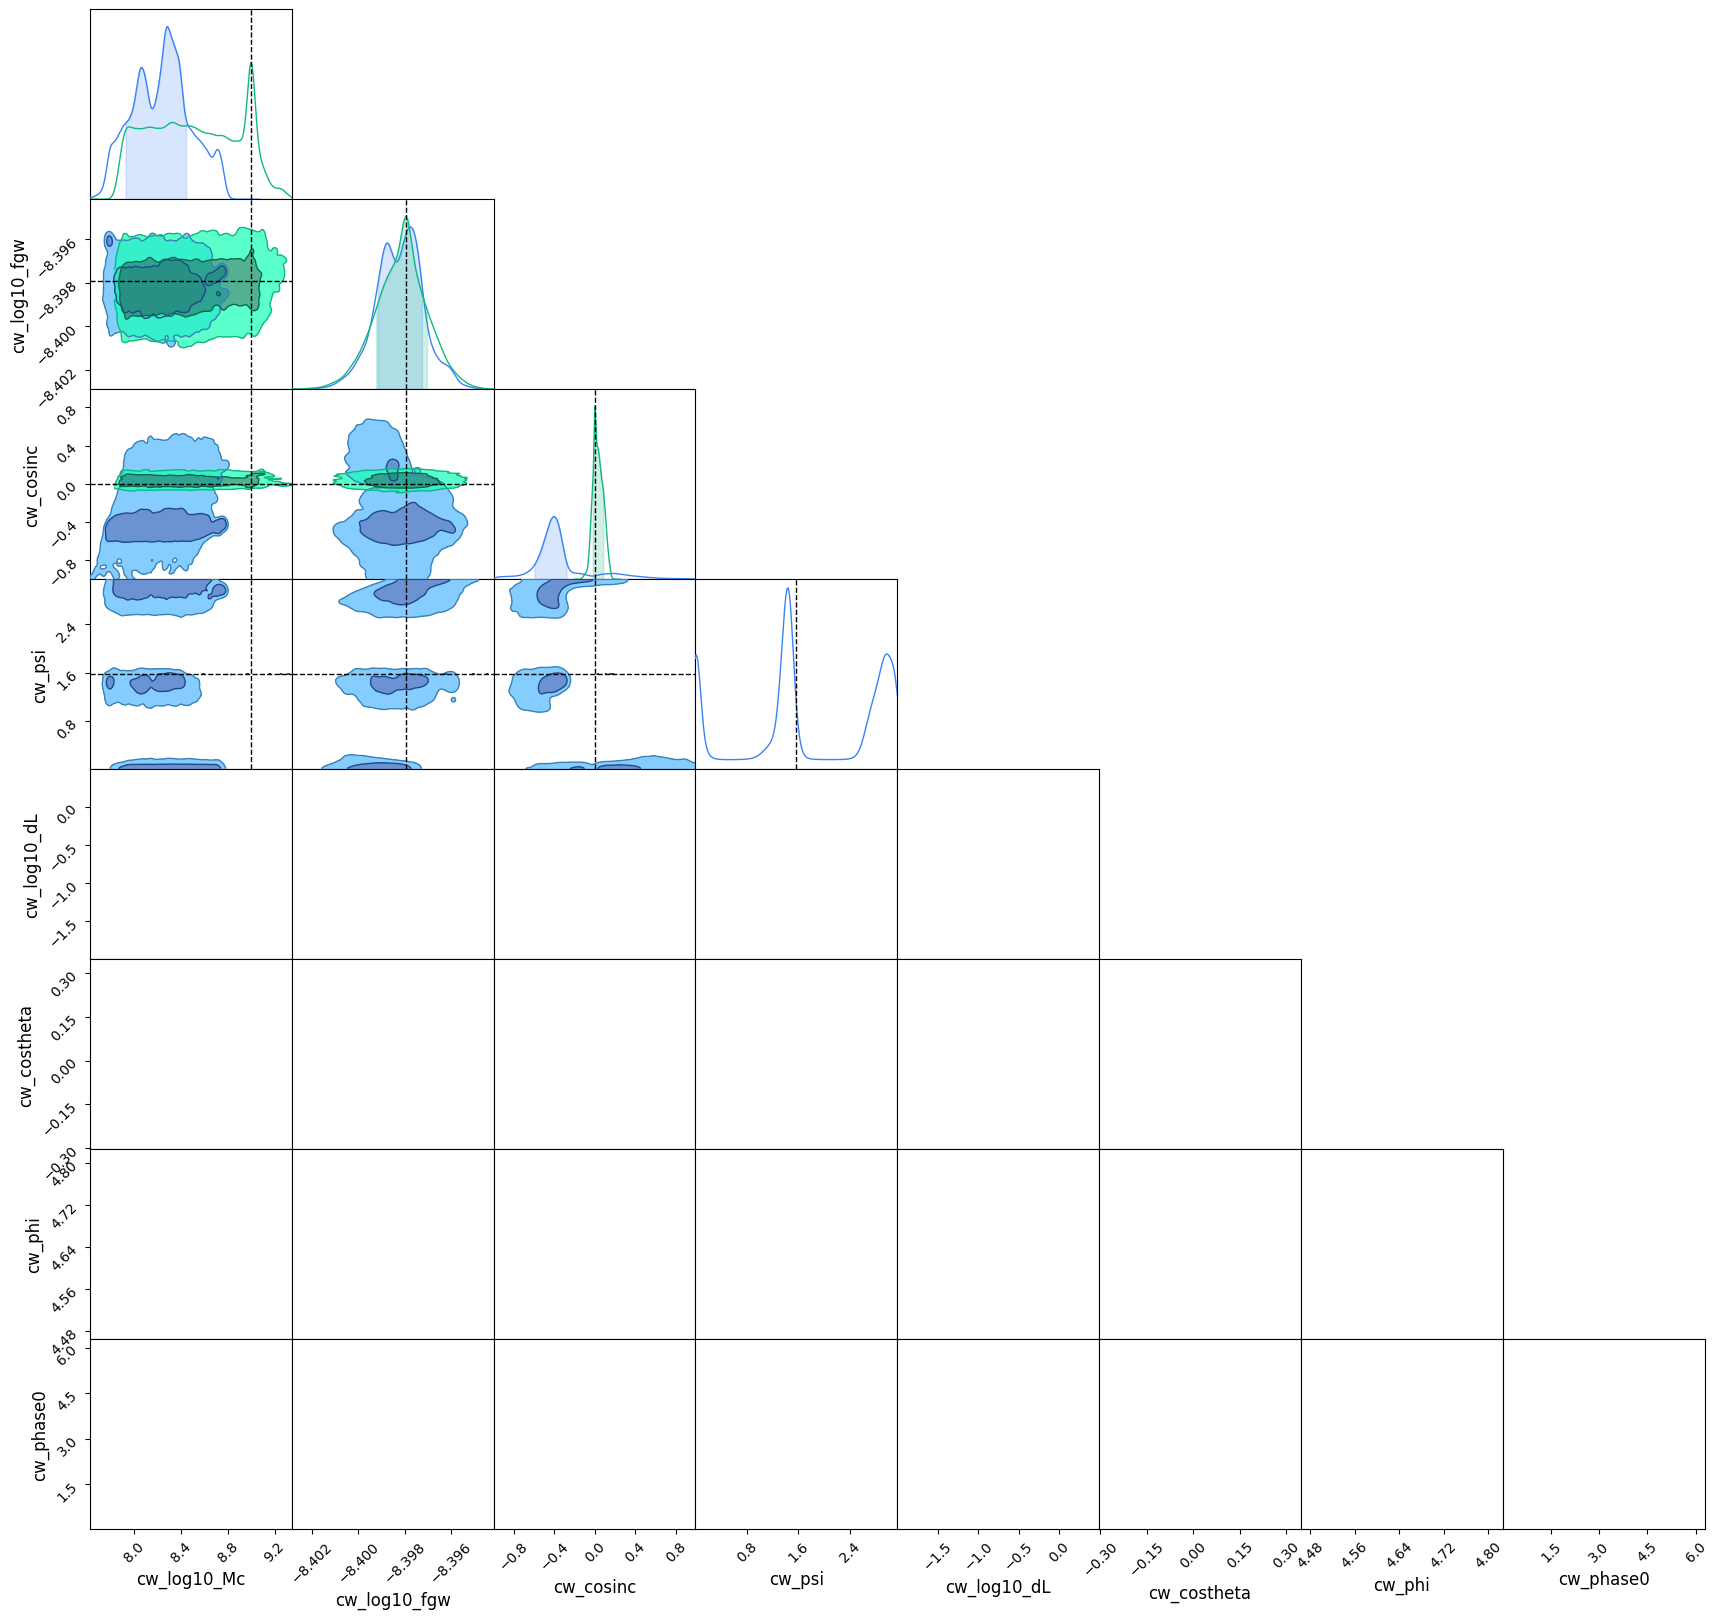

In [30]:
# corner plot
# ndxs = np.r_[:10]
shared_params=['cw_log10_Mc', 'cw_log10_fgw', 'cw_cosinc', 'cw_psi',
                                       'cw_log10_dL', 'cw_costheta', 'cw_phi', 'cw_phase0']
df = pd.DataFrame(cw_samples, columns=['cw_log10_Mc', 'cw_log10_fgw', 'cw_cosinc', 'cw_psi',
                                       'cw_log10_dL', 'cw_costheta', 'cw_phi', 'cw_phase0'])
df_ent = pd.DataFrame(ent_samples_dict)
c = ChainConsumer()
c.add_chain(Chain(samples=df[shared_params], name='HMC'))
c.add_chain(Chain(samples=df_ent[shared_params], name='Enterprise'))
c.add_truth(Truth(location=x_inj_dict))
fig = c.plotter.plot()

In [ ]:
# # Bayesogram
# psr_ndx = 0
# fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (1000,))

# # percentile layers for plotting densities of samples
# percentile_layers = [0.15, 2.5, 16.]
# alphas = [0.2, 0.5, 0.7]

# # plot data, samples, and injected signals
# plt.figure(figsize=(10, 4))
# plt.scatter(data_dict['toas'][psr_ndx] / 86400., data_dict['residuals'][psr_ndx], s=15)
# plt.xlabel('TOAs (MJD)')
# plt.ylabel('timing residuals (s)')

# rn_gwb_signals = np.array([R[psr_ndx] @ data_dict['Fs'][psr_ndx] @ samples_arr[ndx, 2:].reshape((pta_for_parameters.Np, pta_for_parameters.Na))[psr_ndx]
#                             for ndx in fair_draw_ndxs])
# for percentile, alpha in zip(percentile_layers, alphas):
#     if percentile != percentile_layers[-1]:
#         plt.fill_between(data_dict['toas'][psr_ndx] / 86400., np.percentile(rn_gwb_signals, percentile, axis=0),
#                         np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
#                         color='orange', alpha=alpha)
#     else:
#         plt.fill_between(data_dict['toas'][psr_ndx] / 86400., np.percentile(rn_gwb_signals, percentile, axis=0),
#                         np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
#                         color='orange', alpha=alpha, label='RN + GWB samples')

# plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
# plt.ylabel('residuals [s]')
# plt.legend()
# plt.grid()
# plt.show()